In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pandas as pd
import copy
from scipy.special import softmax
from scipy import stats

In [ ]:
def cross_maze(grid_size: int):
    reward = [15,5]
    blocks = []
    mid_a = int(grid_size // 2)
    blocks_a = [[i, mid_a] for i in range(grid_size // 10, grid_size // 10 + 6)]
    blocks_b = [[i, mid_a] for i in range(grid_size - 7, grid_size - 2)]
    blocks_c = [[mid_a, i] for i in range(grid_size // 10 , grid_size - 2)]
    blocks = blocks_a + blocks_b + blocks_c
    valid_starts = []
    for i in range(grid_size):
        for j in range(grid_size):
            # check if position is not in blocks and is at least 10 tiles away from goal
            if [i, j] not in blocks and abs(i - (grid_size - 2)) + abs(j - 1) >= 10:
                valid_starts.append([i, j])
    # choose random start position from valid positions
    agent_start = random.choice(valid_starts)
    return blocks, agent_start, reward

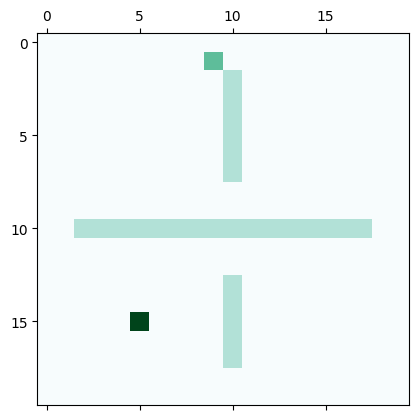

In [ ]:
# plot out the maze
my_maze = cross_maze(20)
maze_blank = np.zeros((20,20))

for x in my_maze[0]:
  maze_blank[x[0],x[1]] = 6
maze_blank[my_maze[1][0],my_maze[1][1]] = 10
maze_blank[my_maze[2][0],my_maze[2][1]] = 19

plt.matshow(maze_blank,cmap='BuGn')

In [ ]:
class QLearningAgent:
    """
    Q-Learning Agent using softmax exploration
    """

    def __init__(
        self,
        env,
        state_size: int,
        lr: float,
        beta: float,
        action_size: int = 4,
        gamma: float = 0.99,
    ):
        self.reward = env[2]
        self.blocks = env[0]
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.beta = beta
        self.Q = np.zeros((state_size, action_size))
        self.M = np.zeros((int(state_size ** 0.5), int(state_size ** 0.5)))

    def choose_action(self, state_idx):
      probs = softmax(self.Q[state_idx, :]*self.beta)
      action = np.random.choice(range(len(probs)), p=probs)
      return action

    def update_Q(self, state_idx, action, reward, next_state_idx, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state_idx, :])
        error = target - self.Q[state_idx, action]
        self.Q[state_idx, action] += self.lr * error

    def step(self, state, action, goal):        
        step_reward = 0
        next_pos = [0, 0]
        if action == 0: #moving up
            next_pos = [state[0] - 1, state[1]]
        elif action == 1: #moving down
            next_pos = [state[0] + 1, state[1]]
        elif action == 2: #moving left
            next_pos = [state[0], state[1] - 1]
        elif action == 3: #moving right
            next_pos = [state[0], state[1] + 1]
            
        if next_pos[0] <= 0 or next_pos[1] <= 0 or next_pos[0] >= int(self.state_size ** 0.5) or next_pos[1] >= int(self.state_size ** 0.5):
            next_state = state
            step_reward = 0
        elif next_pos in self.blocks:
            next_state = state
            step_reward = -0.1
        elif next_pos == self.reward:
            next_state = next_pos
            step_reward = goal
        else:
            next_state = next_pos
            step_reward = 0
        
        next_state_idx = np.ravel_multi_index(next_state, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
        return next_state_idx, step_reward, next_state == self.reward

    def reset_env(self):
      _, state, _ = cross_maze(grid_size)
      self.M = np.zeros((int(state_size ** 0.5), int(state_size ** 0.5)))
      return state

    def train(self, state, max_steps, goal): 
        total_reward = 0
        step = 0
        suc = 0
        state_idx_list = []
        action_list = []
        reward_list = []
        for step in range(max_steps):
            state_idx = np.ravel_multi_index(state, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
            state_idx_list.append(state_idx)
            action = self.choose_action(state_idx)
            action_list.append(action)
            next_state_idx, reward, done = self.step(state, action, goal)
            reward_list.append(reward)
            self.update_Q(state_idx, action, reward, next_state_idx, done)
            state = np.unravel_index(next_state_idx, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
            state = [state[0],state[1]]
            self.M[state[0],state[1]] += 1
            total_reward += reward
            step += 1
            if done:
                suc = 1
                break
        return total_reward, step, self.M, suc, state_idx_list, action_list, reward_list
        
    def replay(self, suc, step, state_idx_list, action_list, reward_list, success):
        my_list = list(range(0, step))
        if suc == success:
          for x in my_list[::-1]:
            # current step
            state_idx = state_idx_list[x-1]
            action = action_list[x-1]
            reward = reward_list[x-1]
            # next step
            next_action = action_list[x]
            next_state_idx = state_idx_list[x]
            # update Q values
            target = reward + self.gamma * self.Q[next_state_idx, next_action]
            error = target - self.Q[state_idx, action]
            self.Q[state_idx, action] += self.lr * error
            if x == 1:
              break

Mean reward (no replay): 4.5424
Mean reward (replay): 8.325599999999998
Independent t-test results:
t-statistic: -8.139942470062962
p-value: 3.1911731507252026e-15


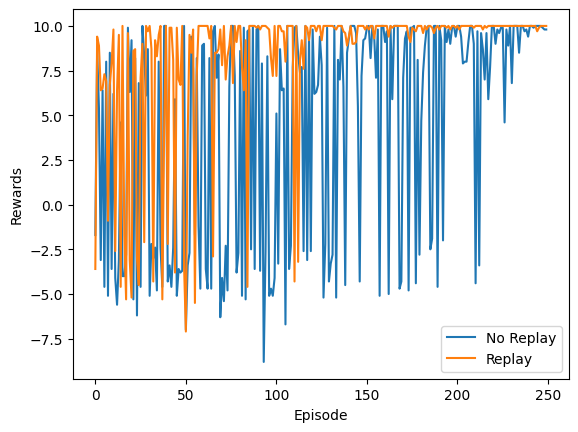

In [ ]:
np.random.seed(47932749)
# Set agent parameters
grid_size = 20
env = cross_maze(grid_size)
state_size = grid_size ** 2
lr = 0.3
beta = 1 
goal = 10
success = 1
n_episodes = 250
max_steps = 1000

# Create Q-learning agent with replay
agent_replay = QLearningAgent(env, state_size, lr, beta)
# Create Q-learning agent with no replay
agent_no_replay = QLearningAgent(env, state_size, lr, beta)

# Create empty lists
steps_replay = []
steps_no_replay = []
rewards_replay = []
rewards_no_replay = []

# Train our agent with and without replay
for episode in range(n_episodes):
    # Train with replay
    state_re = agent_replay.reset_env()
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_replay.train(state_re, max_steps,goal)
    agent_replay.replay(suc, step, state_idx_list, action_list, reward_list, success)
    steps_replay.append(step)
    rewards_replay.append(rews)
    
    # Train without replay
    state = agent_no_replay.reset_env()
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_no_replay.train(state, max_steps,goal)
    steps_no_replay.append(step)
    rewards_no_replay.append(rews)

# Compare the average number of steps
avg_steps_replay = np.mean(steps_replay)
avg_steps_no_replay = np.mean(steps_no_replay)

# Compare the mean rewards
avg_reward_replay = np.mean(rewards_replay)
avg_reward_no_replay = np.mean(rewards_no_replay)

print("Mean reward (no replay):", avg_reward_no_replay)
print("Mean reward (replay):", avg_reward_replay)

# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(rewards_no_replay, rewards_replay)

# Print the results
print("Independent t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Visualize the results (rewards)
plt.plot(rewards_no_replay, label="No Replay")
plt.plot(rewards_replay, label="Replay")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.legend()
plt.show()


Average Number of Steps to Goal (no replay): 517.556
Average Number of Steps to Goal (replay): 208.66
Independent t-test results:
t-statistic: 9.274175915313544
p-value: 5.439305541817671e-19


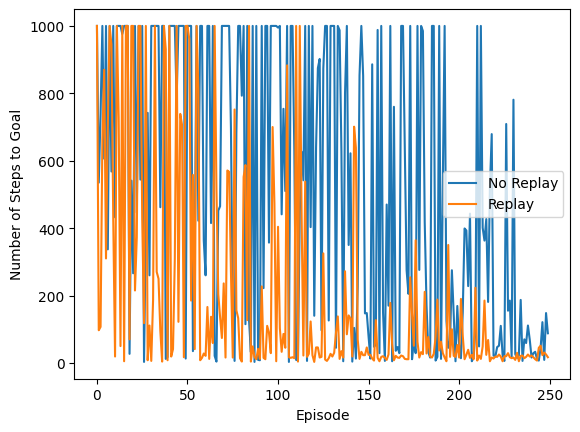

In [ ]:
# Print the Average Number of Steps to Goal
print("Average Number of Steps to Goal (no replay):", avg_steps_no_replay)
print("Average Number of Steps to Goal (replay):", avg_steps_replay)

# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(steps_no_replay, steps_replay)

# Print the results
print("Independent t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Visualize the results (steps)
plt.plot(steps_no_replay, label="No Replay")
plt.plot(steps_replay, label="Replay")
plt.xlabel("Episode")
plt.ylabel("Number of Steps to Goal")
plt.legend()
plt.show()

In [ ]:
np.random.seed(47932749)

# Create empty lists
Qs = [] 
Qs_re = [] 

# Set agent parameters
grid_size = 20
env = cross_maze(grid_size)
state_size = grid_size ** 2
lr = 0.6
beta = 1 
goal = 10
success = 1
n_episodes = 250
max_steps = 1000

# Create Q-learning agent with replay
agent_replay = QLearningAgent(env, state_size, lr, beta)
# Create Q-learning agent with no replay
agent_no_replay = QLearningAgent(env, state_size, lr, beta)

# Train our agent with and without replay
for episode in range(n_episodes):
    # Train with replay
    state_re = agent_replay.reset_env()
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_replay.train(state_re, max_steps,goal)
    agent_replay.replay(suc, step, state_idx_list, action_list, reward_list, success)
    Qs_re.append(copy.deepcopy(agent_replay.Q))
    
    # Train without replay
    state = agent_no_replay.reset_env()
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_no_replay.train(state, max_steps,goal)
    Qs.append(copy.deepcopy(agent_no_replay.Q))


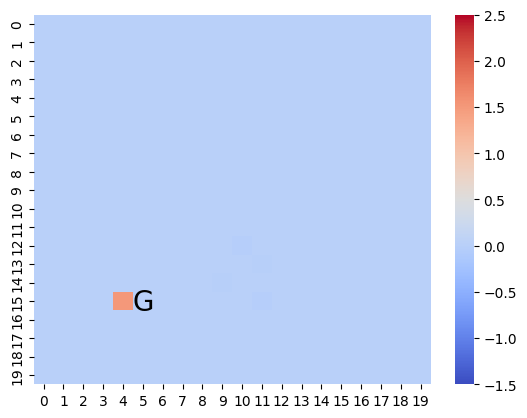

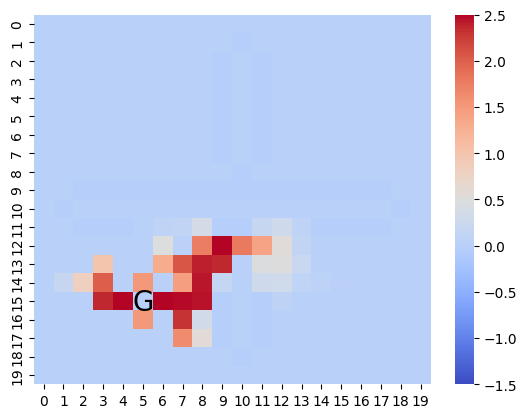

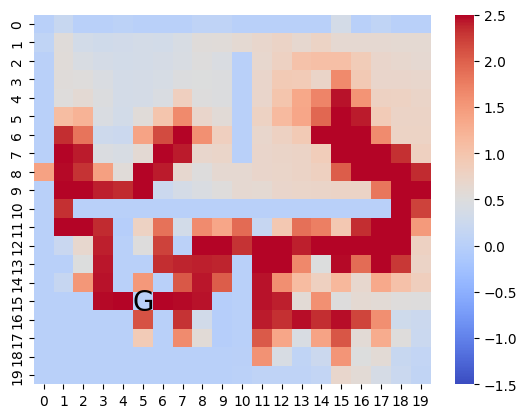

In [ ]:
# No replay
# plot the learned value function after the 1st episode
avg_q_val_1 = []
for i in range(grid_size ** 2):
  n = np.mean(Qs[0][:][i])
  avg_q_val_1.append(n)

avg_q_val_1 = np.array(avg_q_val_1)
q_map_1 = avg_q_val_1.reshape((grid_size, grid_size))
sns.heatmap(q_map_1, cmap='coolwarm', vmin=-1.5, vmax=2.5)
plt.annotate('G', xy=(5, 16), fontsize=20)
plt.show()

# plot the learned value function after the 50th episode
avg_q_val_2 = []
for i in range(grid_size ** 2):
  n = np.mean(Qs[49][:][i])
  avg_q_val_2.append(n)

avg_q_val_2 = np.array(avg_q_val_2)
q_map_2 = avg_q_val_2.reshape((grid_size, grid_size))
sns.heatmap(q_map_2, cmap='coolwarm', vmin=-1.5, vmax=2.5)
plt.annotate('G', xy=(5, 16), fontsize=20)
plt.show()

# plot the learned value function after the 250th episode
avg_q_val_3 = []
for i in range(grid_size ** 2):
  n = np.mean(Qs[-1][:][i])
  avg_q_val_3.append(n)

avg_q_val_3 = np.array(avg_q_val_3)
q_map_3 = avg_q_val_3.reshape((grid_size, grid_size))
sns.heatmap(q_map_3, cmap='coolwarm', vmin=-1.5, vmax=2.5)
plt.annotate('G', xy=(5, 16), fontsize=20)
plt.show()

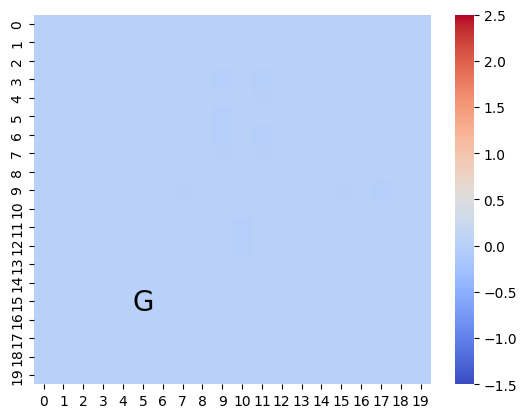

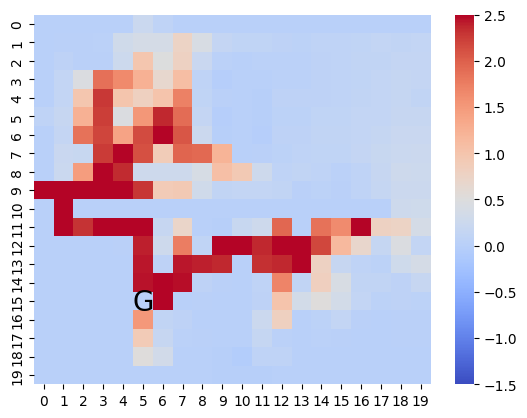

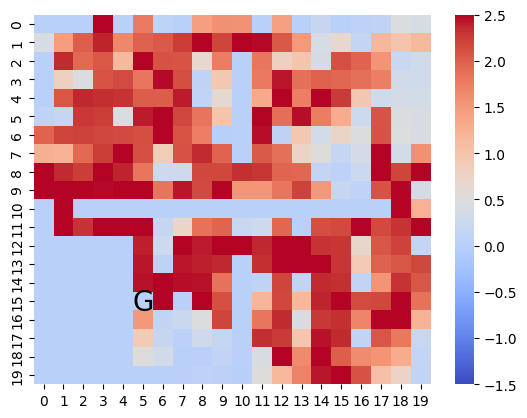

In [ ]:
# Replay
# plot the learned value function after the 1st episode
avg_q_val_1 = []
for i in range(grid_size ** 2):
  n = np.mean(Qs_re[0][:][i])
  avg_q_val_1.append(n)

avg_q_val_1 = np.array(avg_q_val_1)
q_map_1 = avg_q_val_1.reshape((grid_size, grid_size))
sns.heatmap(q_map_1, cmap='coolwarm', vmin=-1.5, vmax=2.5)
plt.annotate('G', xy=(5, 16), fontsize=20)
plt.show()

# plot the learned value function after the 50th episode
avg_q_val_2 = []
for i in range(grid_size ** 2):
  n = np.mean(Qs_re[49][:][i])
  avg_q_val_2.append(n)

avg_q_val_2 = np.array(avg_q_val_2)
q_map_2 = avg_q_val_2.reshape((grid_size, grid_size))
sns.heatmap(q_map_2, cmap='coolwarm', vmin=-1.5, vmax=2.5)
plt.annotate('G', xy=(5, 16), fontsize=20)
plt.show()

# plot the learned value function after the 250th episode
avg_q_val_3 = []
for i in range(grid_size ** 2):
  n = np.mean(Qs_re[249][:][i])
  avg_q_val_3.append(n)

avg_q_val_3 = np.array(avg_q_val_3)
q_map_3 = avg_q_val_3.reshape((grid_size, grid_size))
sns.heatmap(q_map_3, cmap='coolwarm', vmin=-1.5, vmax=2.5)
plt.annotate('G', xy=(5, 16), fontsize=20)
plt.show()